This is code to generate the figure for looking at glucose uptake rate in wild-type versus glgP. An ion corresponding to a glucose adduct was used to calculate the glucose uptake rate.

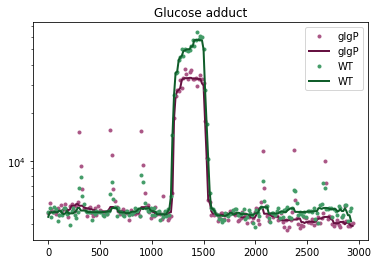

In [7]:
#load the data, annotations, and initialize

import sys
sys.path.append("../common") #where to keep all of the custom, common functions

import numpy as np
import csv
import matplotlib.pyplot as plt
import fiaannparse as fp
import pandas as pd
from scipy.signal import medfilt
from matplotlib.backends.backend_pdf import PdfPages

#specify where the data is
datadirectory = "./"

#specify the datasets of interest and their current location. we have an omit range due to problems with measurement
datasets = {'E222502': {'name': 'glgP','delta': 15, 'ODi': 1.068, 'omit': [], 'color': '#AA5585', 'darkcolor': '#661141'},
            'E222504': {'name': 'WT','delta': 15, 'ODi': 1.06, 'omit': [], 'color': '#439C68', 'darkcolor': '#105D2A'}
            }

setsOfInterest = [item for item in datasets.keys()]

#load the data into new dictionary where the top level key is the dataset
sweetdata = {}
for item in datasets.keys():
    csvfile = datadirectory + item + '/' + item + '.csv'
    sweetdata[item] = {}
    sweetdata[item]['data'] = np.loadtxt(open(csvfile, "rb"), delimiter=",")
    sweetdata[item]['condition'] = datasets[item]['name']
    sweetdata[item]['delta'] = datasets[item]['delta']
    sweetdata[item]['ODi'] = datasets[item]['ODi']
    sweetdata[item]['omit'] = datasets[item]['omit']
    sweetdata[item]['color'] = datasets[item]['color']
    sweetdata[item]['darkcolor'] = datasets[item]['darkcolor']

#generate a union dictionary of all of the annotations
theDictOfDict = {}
union = set()

#parse the annotation file for each dataset and construct a super dictionary
for item in setsOfInterest:
    #see the common folder for the code to annotation file parser
    theDictOfDict[item] = fp.parseAnnotationExcel(datadirectory + item  + '/annotation' + item + '.xls')
    #at the same time figure out all of the metabolites measured among all of the annotation files
    union = union | set(theDictOfDict[item])
    
#consolidate everything by annotated metabolites into a dictionary
compileDict ={}
for key in union:
    compileDict[key] = {}
    for item in setsOfInterest:
        try:
            compileDict[key][item] = theDictOfDict[item][key]['ion']
            compileDict[key]['name'] =  theDictOfDict[item][key]['name']
        except KeyError:
            compileDict[key][item] = 'NaN'

#glucose adduct
ionofint = ['C11434']


#go through and make figures for each metabolite
for ion in ionofint:
    #and go through each set of interest
    for item in setsOfInterest:
        currentind = compileDict[ion][item]-1
        
        #make the x value range (first remove the omitted points)
        x = set(range(0,(len(sweetdata[item]['data'][:,currentind])))) - set(sweetdata[item]['omit'])
        #space out by the temporal resolution of the RT metabolomics measurement
        x = np.array(list(x))*sweetdata[item]['delta']
        x.sort()
        
        #get the y data and remove the omitted points
        y = sweetdata[item]['data'][:,currentind]
        y = np.delete(y,[sweetdata[item]['omit']])
        
        #make the smoothed filter curve
        filtered = medfilt(y/sweetdata[item]['ODi'],  kernel_size=9)
        
        #plot the points
        plt.semilogy(x,y/sweetdata[item]['ODi'], '.', label=sweetdata[item]['condition'], color = sweetdata[item]['color'])
        
        #plot the smoothed data
        plt.semilogy(x,filtered, label=sweetdata[item]['condition'], color = sweetdata[item]['darkcolor'], linewidth = 2)
    
    #label our plot
    plt.legend()
    plt.title('Glucose adduct')
    plt.show();